In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from scipy.stats import qmc, norm
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', font_scale=1.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [3]:
data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

msft_calls = pd.read_pickle('data/msft_calls.pickle')
msft_puts = pd.read_pickle('data/msft_puts.pickle')
expirations = pd.read_pickle('data/expirations.pickle')

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [4]:
maturities = [
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
]

In [5]:
def real_data_to_format(real_df, real_price, maturity, risk_free_rate):
    df = pd.DataFrame()
    df['S2K'] = real_price / real_df.strike
    df['T'] = maturity
    df['r'] = risk_free_rate
    df['sigma'] = real_df.impliedVolatility
    df['V2K'] = real_df.lastPrice / real_df.strike
    # df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
    # df = df.loc[df.time_value > 1e-7].copy()
    # df['log_time_value'] = np.log(df['time_value'])
    # 0/0
    df = df.loc[(df.V2K > 1e-7) & (df.S2K > 1e-7)].copy()
    df['log_V2K'] = np.log(df['V2K'])
    df['log_S2K'] = np.log(df['S2K'])
    return df

In [6]:
idx = 2 
real_df_concated = pd.concat([
    real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05) for idx in range(len(msft_calls))
])
display(real_df_concated.head())
real_df_concated.info()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
0,3.679875,0.007812,0.05,8.390630,2.614375,0.961025,1.302879
1,3.463412,0.007812,0.05,7.537110,2.432941,0.889101,1.242254
2,3.271000,0.007812,0.05,7.299806,2.224444,0.799507,1.185096
3,3.098842,0.007812,0.05,6.007815,2.151053,0.765957,1.131029
4,2.943900,0.007812,0.05,6.179690,1.834000,0.606499,1.079735


<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 0 to 67
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S2K      978 non-null    float64
 1   T        978 non-null    float64
 2   r        978 non-null    float64
 3   sigma    978 non-null    float64
 4   V2K      978 non-null    float64
 5   log_V2K  978 non-null    float64
 6   log_S2K  978 non-null    float64
dtypes: float64(7)
memory usage: 61.1 KB


In [7]:
real_df_concated.describe()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,978.000000,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000
mean,1.143550,0.743857,5.000000e-02,0.566510,0.259377,-3.532163,0.056342
std,0.513673,0.749395,6.595322e-16,1.047488,0.438352,3.002779,0.375321
min,0.566135,0.007812,5.000000e-02,0.000010,0.000019,-10.858999,-0.568923
25%,0.795649,0.113281,5.000000e-02,0.291809,0.004594,-5.383341,-0.228598
50%,0.997932,0.472656,5.000000e-02,0.346030,0.062926,-2.765793,-0.002070
75%,1.308400,1.210938,5.000000e-02,0.497136,0.306436,-1.182748,0.268805
max,3.679875,2.632812,5.000000e-02,14.885255,2.614375,0.961025,1.302879


### Parameters distributions

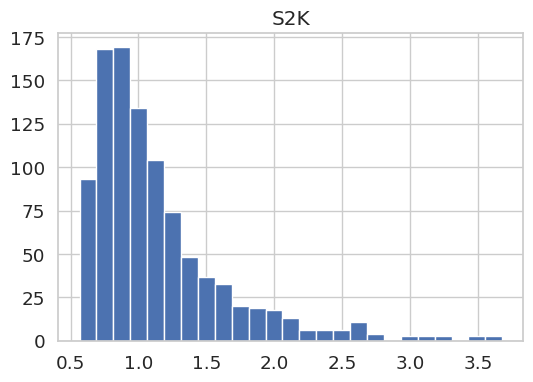

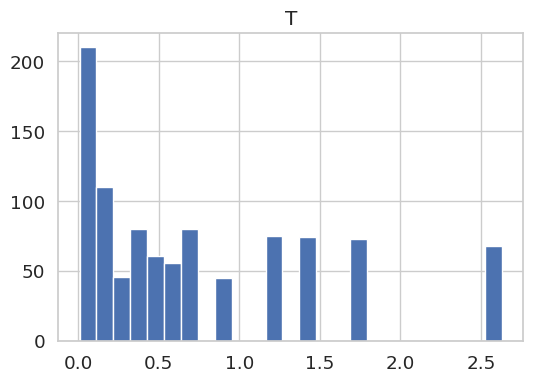

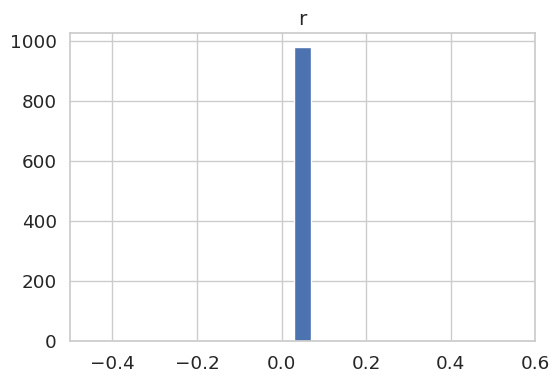

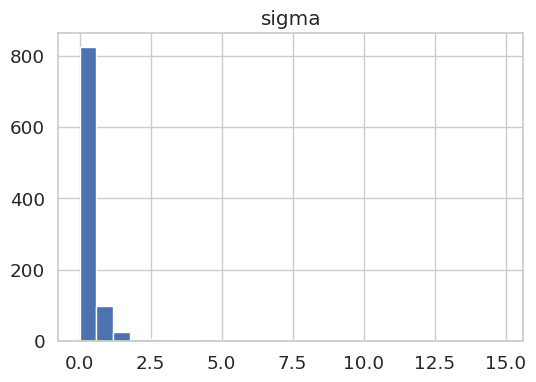

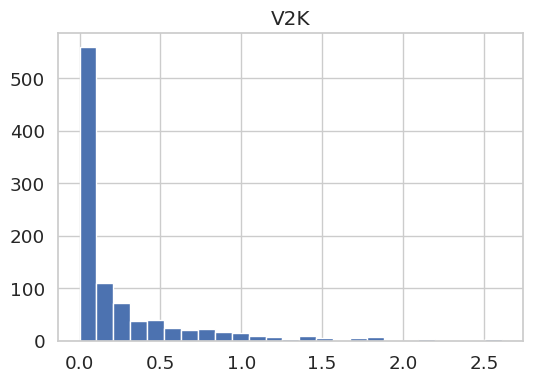

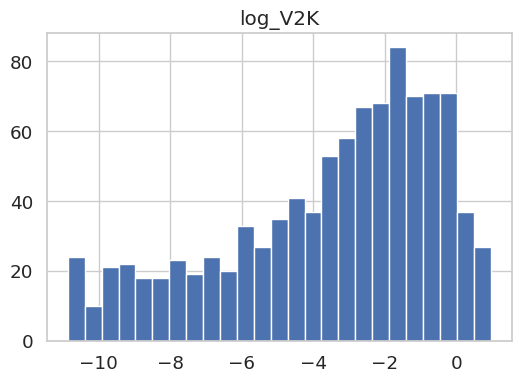

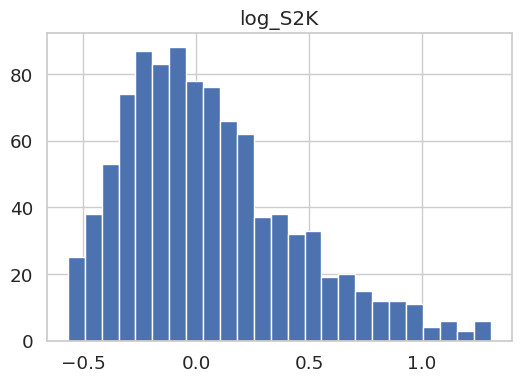

In [8]:
for col in real_df_concated.columns:
    plt.figure(figsize=(6,4))
    plt.title(col)
    plt.hist(real_df_concated[col], bins=25)
    plt.show()

In [9]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

In [14]:
print(st._continuous_distns._distn_names)

['ksone', 'kstwo', 'kstwobign', 'norm', 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'fisk', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'fatiguelife', 'foldcauchy', 'f', 'foldnorm', 'weibull_min', 'truncweibull_min', 'weibull_max', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gamma', 'erlang', 'gengamma', 'genhalflogistic', 'genhyperbolic', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'gausshyper', 'invgamma', 'invgauss', 'geninvgauss', 'norminvgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'laplace', 'laplace_asymmetric', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'gibrat', 'gilbrat', 'maxwell', 'mielke', 'kappa4', 'kappa3', 'moyal', 'nakagami', 'ncx2', 'ncf', 't', 'nct', 'pareto', 'lomax', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'loguniform', 'reciprocal', 'rice', 'recipinvga

In [21]:
distr_list = [
    'norm',
    'expon',
    'gamma',
    'lognorm',
    't',
    'uniform'
]

In [18]:
getattr(st, 'uniform')

In [24]:
def fit_distribution(data, distr_list=None, bins=200, ax=None):
    if distr_list is None:
        distr_list = [d for d in st._continuous_distns._distn_names if not d in ['levy_stable', 'studentized_range']]
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distr_name in enumerate(distr_list):

        distribution = getattr(st, distr_name)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse, distr_name))
        
        except Exception:
            pass

    best_distributions = sorted(best_distributions, key=lambda x:x[2])

    report = pd.DataFrame({
        'Name' : [d[3] for d in best_distributions],
        'SSE' : [d[2] for d in best_distributions],
        'Num params' : [len(d[1]) for d in best_distributions]
    })
    
    return best_distributions, report

In [20]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [25]:
data = real_df_concated.S2K

best_distibutions, report = fit_distribution(data, distr_list, 50)
best_dist = best_distibutions[0]
report.head()

,Name,SSE,Num params
0,lognorm,0.251091,3
1,gamma,0.490258,3
2,t,1.297200,3
3,expon,2.013035,2
4,norm,3.537644,2


<Axes: ylabel='Frequency'>

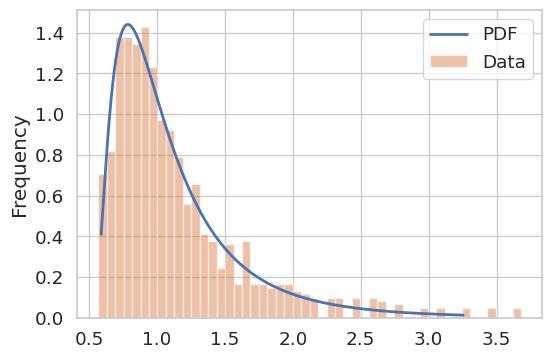

In [27]:
# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(6,4))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

In [31]:
real_df_concated.columns

Index(['S2K', 'T', 'r', 'sigma', 'V2K', 'log_V2K', 'log_S2K'], dtype='object')

Feature: S2K


,Name,SSE,Num params
0,lognorm,0.251091,3
1,gamma,0.490258,3
2,t,1.297200,3
3,expon,2.013035,2
4,norm,3.537644,2


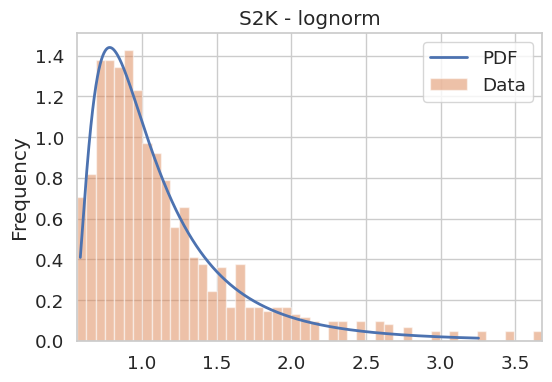

Feature: sigma


,Name,SSE,Num params
0,lognorm,0.446761,3
1,t,0.933798,3
2,expon,1.229232,2
3,norm,2.702712,2
4,gamma,3.396344,3


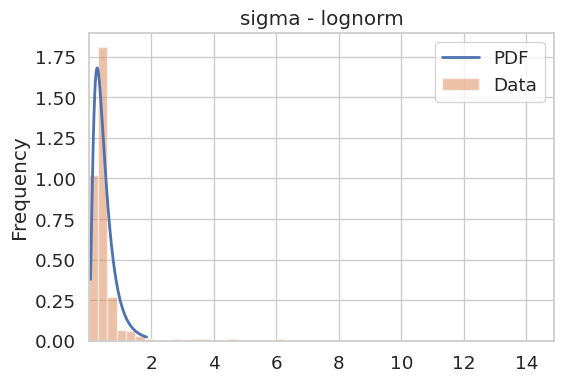

Feature: log_V2K


,Name,SSE,Num params
0,t,0.080822,3
1,norm,0.080830,2
2,lognorm,0.083842,3
3,gamma,0.088302,3
4,uniform,0.113451,2


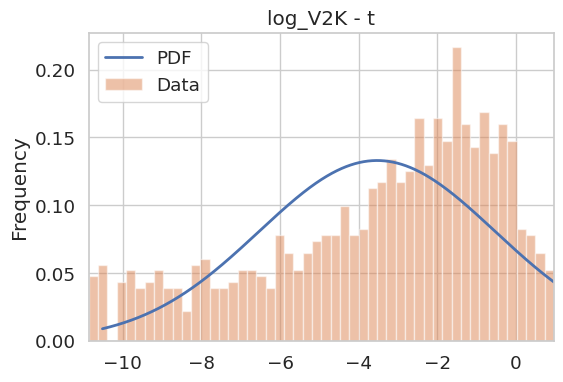

In [34]:
distributions = {}
for col in ['S2K', 'sigma', 'log_V2K']:
    data = real_df_concated[col]
    best_distibutions, report = fit_distribution(data, distr_list, 50)
    best_dist = best_distibutions[0]
    distributions[col] = best_dist
    print(f'Feature: {col}')
    display(report.head())
    
    # Display
    pdf = make_pdf(best_dist[0], best_dist[1])
    plt.figure(figsize=(6,4))
    plt.title(f'{col} - {best_dist[3]}')
    plt.xlim((data.min(), data.max()))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    plt.show()

In [35]:
distributions

{'S2K': (<scipy.stats._continuous_distns.lognorm_gen at 0x7f4ba0b71120>,
  (0.7401529360133818, 0.49947625793119815, 0.4922792079848358),
  0.25109106005948045,
  'lognorm'),
 'sigma': (<scipy.stats._continuous_distns.lognorm_gen at 0x7f4ba0b71120>,
  (0.6004844107087832, -0.06461656687736297, 0.4735432064815713),
  0.44676069224673026,
  'lognorm'),
 'log_V2K': (<scipy.stats._continuous_distns.t_gen at 0x7f4ba0b73fa0>,
  (7848190.048119344, -3.5320381128054503, 3.001298189352656),
  0.08082221195729357,
  't')}

In [69]:
import pickle
with open('distributions.pkl', 'wb') as f:
    pickle.dump(distributions, f)

### Sampling

In [57]:
def sample_distr(distr_info, size):
    distr = distr_info[0]
    params = distr_info[1]
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    return distr.rvs(size=size, *arg, loc=loc, scale=scale) if arg else distr.rvs(size=size, loc=loc, scale=scale)

In [ ]:
# old approach
n_samples = 1_000_000
bounds_dict = {
    'S2K' : (0.25, 4),
    'T' : (0.01, 2),
    'r' : (0.01, 0.1),
    'sigma' : (0.01, 15)
}
l_bounds = [i[0] for k,i in bounds_dict.items()]
r_bounds = [i[1] for k,i in bounds_dict.items()]
lhc = qmc.LatinHypercube(d=4)
bs_params = qmc.scale(lhc.random(n=n_samples), l_bounds, r_bounds)
bs_params.shape

In [68]:
n_samples = 10_000
bs_params = np.vstack([
    sample_distr(distributions['S2K'], n_samples), 
    np.random.uniform(0.01, 2, n_samples), # T
    np.random.uniform(0.01, 0.1, n_samples), # r
    sample_distr(distributions['sigma'], n_samples),
]).T
bs_params.shape

(10000, 4)

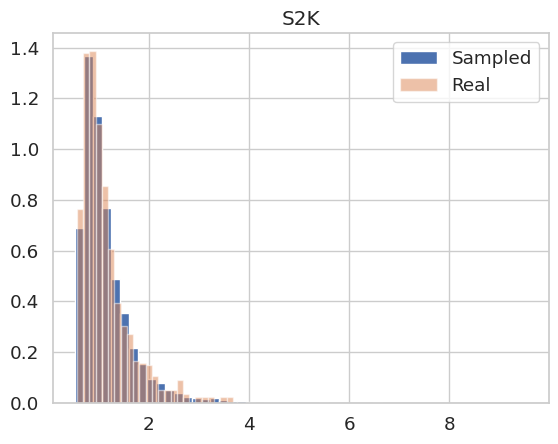

In [70]:
plt.hist(bs_params[:,0], bins=50, label='Sampled', density=True, alpha=1)
plt.hist(real_df_concated.S2K, bins=25, label='Real', density=True, alpha=0.5)
plt.title('S2K')
plt.legend();

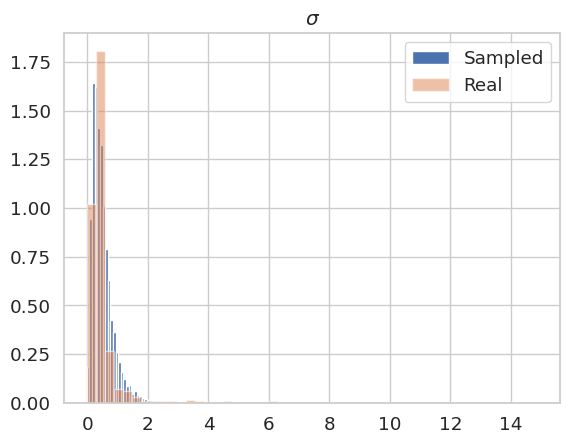

In [74]:
plt.hist(bs_params[:,3], bins=50, label='Sampled', density=True, alpha=1)
plt.hist(real_df_concated.sigma, bins=50, label='Real', density=True, alpha=0.5)
plt.title('$\sigma$')
plt.legend();

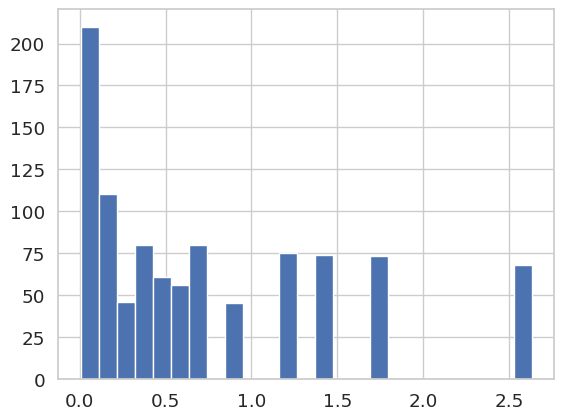

In [85]:
plt.hist(real_df_concated['T'], bins=25);

In [1]:
2+2

4